In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import io
import tensorflow as tf
%matplotlib inline

2024-09-23 02:02:27.895997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 02:02:27.904153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 02:02:27.912892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 02:02:27.915500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 02:02:27.923291: I tensorflow/core/platform/cpu_feature_guar

## Defining the Data-Reuploading Model
Setting up the [pennylane device](https://docs.pennylane.ai/en/stable/code/api/pennylane.device.html). The device defines the number of qubit in the ciruit and the backend (i.e type of simulator, real device, etc).

In [2]:
dev = qml.device("lightning.qubit",wires=1)

We create our variational model. Every [*'Rot'*](https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html) operation is the [$R_X$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html),[$R_Y$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RY.html),[$R_Z$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html) applied in series. Our weight vector will hence have the shape [n_layers,3], which in this case is [3,3] (3 layers)

Data Reuploading Classifiers use only a singel qubit. As part of the [Data Reuploading](https://arxiv.org/abs/1907.02085) scheme, every layer starts by *'reuploading'* the data (i.e. encoding the data again). This creates a non-trivial function of the input data on the state vector of our single qubit.

In [3]:
@qml.qnode(dev, interface='tf')
def DR_model(input, weights):
    for layer in range(weights.shape[0]):
        qml.RX(input[0],wires=0)
        qml.RY(input[1],wires=0)
        qml.Rot(*weights[layer], wires=0)
    return qml.expval(qml.PauliZ(0))

In [4]:
input = tf.constant([0.5, 0.1])
weights = tf.Variable(np.random.randn(3,3))

2024-09-23 02:02:30.159343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


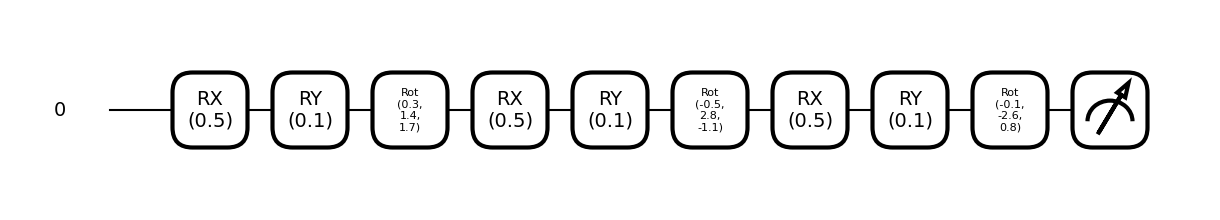

In [5]:
fig = qml.draw_mpl(DR_model,expansion_strategy="device",decimals=1)(input,weights)
plt.savefig("./DRModel.png")

## Loading our dataset

In [6]:
x = np.load("./Saved_vars/3Layer/x_3.npy")
y = np.load("./Saved_vars/3Layer/y_3.npy")
true_labels = np.load("./Saved_vars/3Layer/labels_3.npy")

We need to stack our 'x' and 'y' for our variational model to accept the inputs

In [7]:
data = tf.stack([x,y],axis=1)
print(data.shape)

(1024, 2)


**Data Pre-Processing**: We need to change our label range from $\{-1,1\} \rightarrow \{0,1\}$ we can do this via the simple transform function:
$$
f(x) = \frac{x+1}{2} \tag{1}
$$
As this function is monotonic, the <u>transformation will not affect our optimization objective</u>

In [8]:
@tf.function
def expectation_range_transform(x):
    return tf.divide(tf.add(x,1),2)

In [9]:
labels = expectation_range_transform(true_labels)

### Plotting our data
To see the decision boundry, we plot our dataset

In [10]:
def plot_preds(labels,x,y,title='Target dataset',get_img:bool=False):
    for label in set(labels):
        x_subset = [x_i for i, x_i in enumerate(x) if labels[i] == label]
        y_subset = [y_i for i, y_i in enumerate(y) if labels[i] == label]
        marker = 'v' if label == 0.0 else 'x'  # Example markers: 'o' for circles, 'x' for crosses
        plt.scatter(x_subset, y_subset, label=label, marker=marker)
    
    # Add labels, title, and legend
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    if(get_img):
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = tf.image.decode_png(buf.getvalue(), channels=3)
        buf.close()
        plt.show()
        return tf.expand_dims(img,0)
    plt.show()

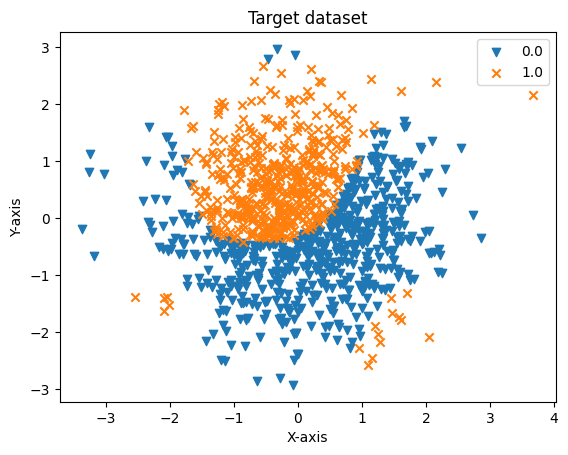

In [11]:
target_img = plot_preds(labels.numpy(),x,y,get_img=True)

## Training the model
Training will require multiple components to be step up - (1). The Forward & Backward passes, (2). Our optimizer & loss functions and (3). The training loop 

### Foward & Backward Pass
Our forward pass will run our model and apply the expectation_range_transform function from equation (1). 

In [12]:
def forward_pass(data,weights):
    result = DR_model(data, weights)
    result = expectation_range_transform(result)
    return tf.expand_dims(tf.expand_dims(result,0),0)

**Training Set-Up**
We will be using [Binary Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) to train our model with the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

In [13]:
lossfn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.3)

**Gradients**: We wrap our forward pass inside tf.GradientTape for training. [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) will automatically get the gradients from the forward pass via [automatic differentiation](https://www.tensorflow.org/guide/autodiff)

In [14]:
with tf.GradientTape() as tape:
    result = forward_pass(data[0],weights)
    loss = lossfn(tf.expand_dims(labels[0],0),result)

In [15]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.41360322>

In [16]:
weights

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float64, numpy=
array([[ 0.31982928,  1.36322141,  1.73601725],
       [-0.53224747,  2.78700619, -1.08691267],
       [-0.08834046, -2.57635545,  0.75727484]])>

In [17]:
grad = tape.gradient(loss,weights)

2024-09-23 02:02:49.496812: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


In [18]:
print(grad)

tf.Tensor(
[[-0.71552637 -0.01652777 -0.14982372]
 [ 0.31539428  0.46488639 -0.14180033]
 [-0.36761409  0.20296837  0.        ]], shape=(3, 3), dtype=float64)


**Applying Gradients**: To apply the gradients, we use the optimizer's ['apply_gradients'](https://www.tensorflow.org/api_docs/python/tf/keras/Optimizer#apply_gradients) method.

In [19]:
grad.shape

TensorShape([3, 3])

In [20]:
weights.shape

TensorShape([3, 3])

In [21]:
print(weights)
opt.apply_gradients(zip([grad],[weights]))
print("-"*20,"AFTER APPLYING GRADIENTS","-"*20)
print(weights)

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float64, numpy=
array([[ 0.31982928,  1.36322141,  1.73601725],
       [-0.53224747,  2.78700619, -1.08691267],
       [-0.08834046, -2.57635545,  0.75727484]])>
-------------------- AFTER APPLYING GRADIENTS --------------------
<tf.Variable 'Variable:0' shape=(3, 3) dtype=float64, numpy=
array([[ 0.61982596,  1.66316203,  2.03600892],
       [-0.83224247,  2.48701022, -0.78692135],
       [ 0.21165497, -2.87634878,  0.75727484]])>


**Utility Function -> Plot Model** helps us plot the current predictions of the model

In [22]:
def get_model_preds(data,weights):
    labels = []
    for datapoint in data:
        labels.append(np.sign(DR_model(datapoint,weights)))
    return expectation_range_transform(labels)

### Training loop over data
We set up the training parameters such as number of epochs, etc

*Notes:*
1. We will not be training in batches directly due to limitations in Pennylanes ability to execute batches of data on circuits and the small size of the dataset
2. We are reintiating the optimizer again due to needing to resetting the weights


In [23]:
epochs = 6
batch_size = 32
step_size = data.shape[0]//batch_size
# opt = tf.keras.optimizers.Adam(learning_rate=0.03)
opt = tf.keras.optimizers.SGD(learning_rate=0.03)
print("step_size:",step_size)

step_size: 32


Reshape the dataset and labels to be in batches

In [24]:
dataset = tf.reshape(data,[step_size,batch_size]+[data.shape[-1]],name="BatchedData")
y_true = tf.reshape(labels,(step_size,batch_size,1),name="BatchedData")

In [25]:
dataset.shape

TensorShape([32, 32, 2])

In [26]:
run = 5
logdir = f"logs/train_data/DataReuploading/run_{run}"
file_writer = tf.summary.create_file_writer(logdir)
description = f"Data Reuploader run {run} -> layers {weights.shape[0]} | {weights.shape[0] *3}  Trainable Parameters | {epochs} Epochs"
print(description)

Data Reuploader run 4 -> layers 3 | 9  Trainable Parameters | 6 Epochs


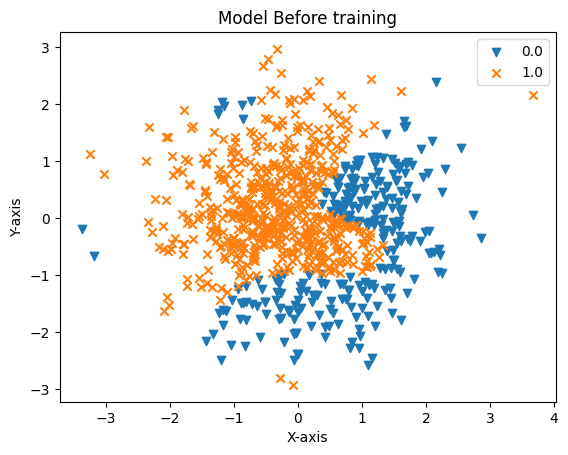

In [27]:
y_preds = get_model_preds(data[:800],weights)
plots = plot_preds(y_preds.numpy(),data[:800,0],data[:800,1],title=f"Model Before training",get_img=True)
with file_writer.as_default():
    tf.summary.image("Training Progress", plots, step=-1)
    tf.summary.text("Run Description", description, step=-1)

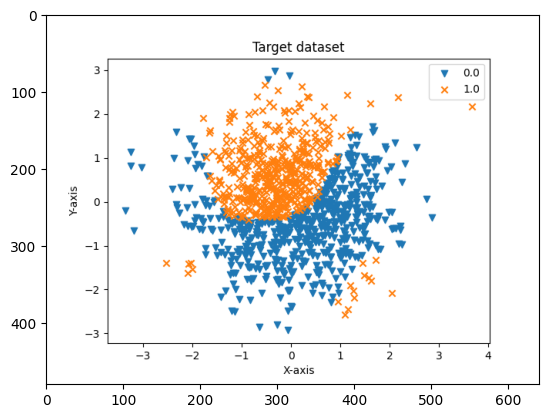

In [28]:
plt.imshow(target_img[0])

In [29]:
with file_writer.as_default():
  tf.summary.image("Target Data", target_img, step=0)

2024-09-23 02:02:57.165698: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]
2024-09-23 02:02:57.192743: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]
2024-09-23 02:02:57.286705: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]
2024-09-23 02:02:57.440073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]
2024-09-23 02:02:57.665358: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


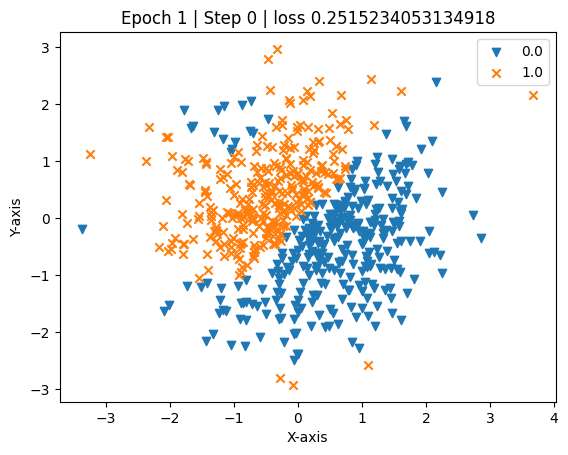

2024-09-23 02:03:00.230044: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


2024-09-23 02:03:01.331644: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


2024-09-23 02:03:03.295999: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


2024-09-23 02:03:07.418912: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


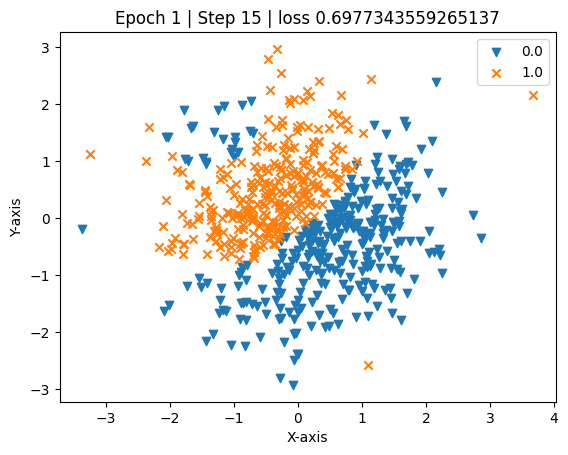

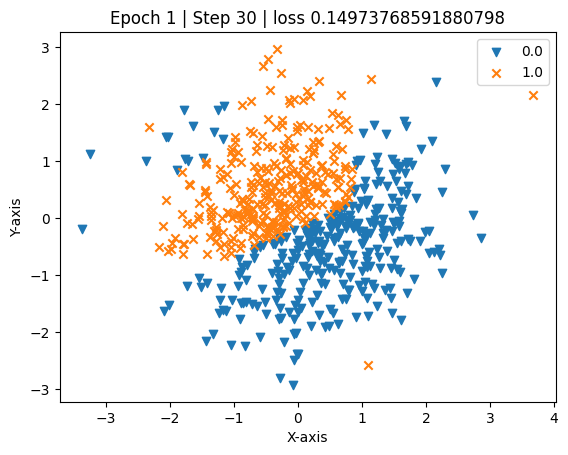

2024-09-23 02:03:19.041162: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


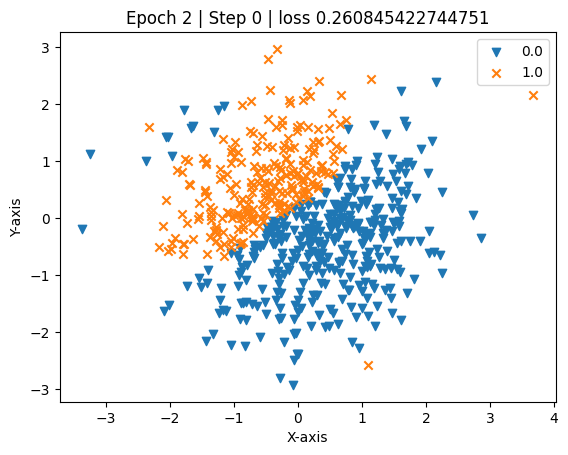

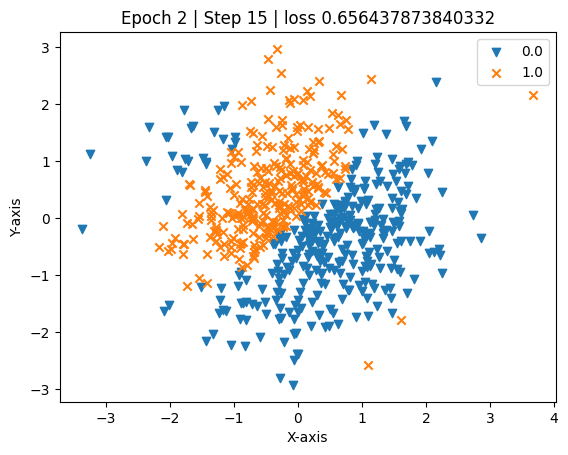

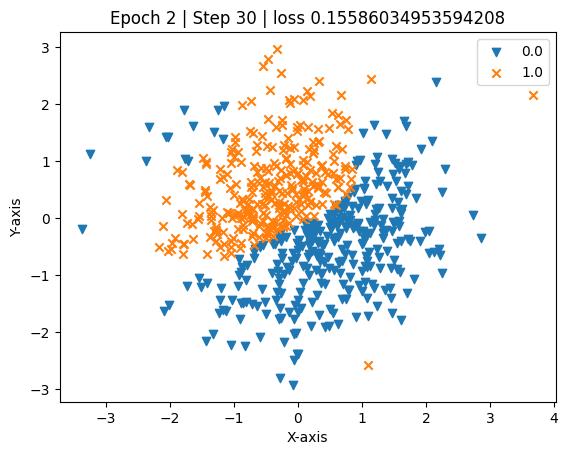

2024-09-23 02:03:39.914301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


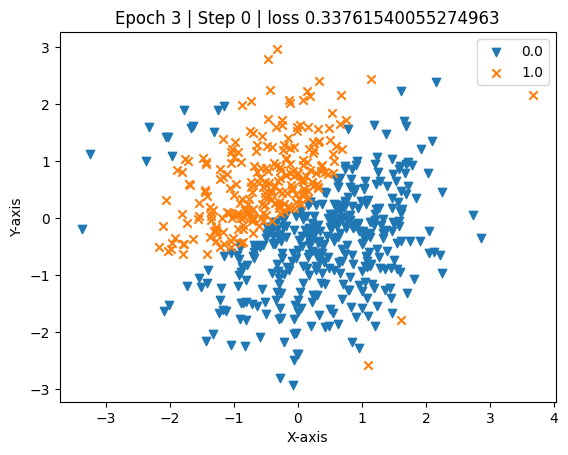

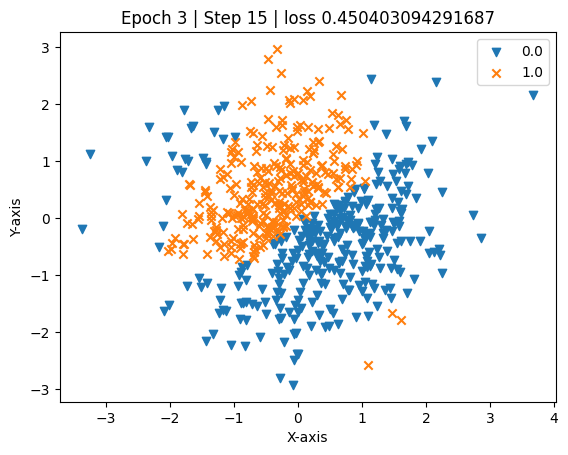

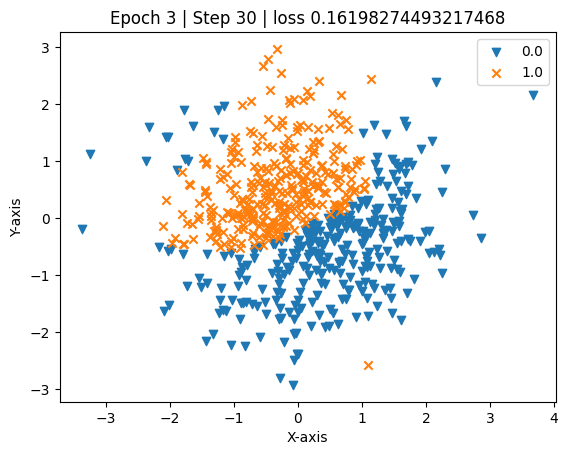

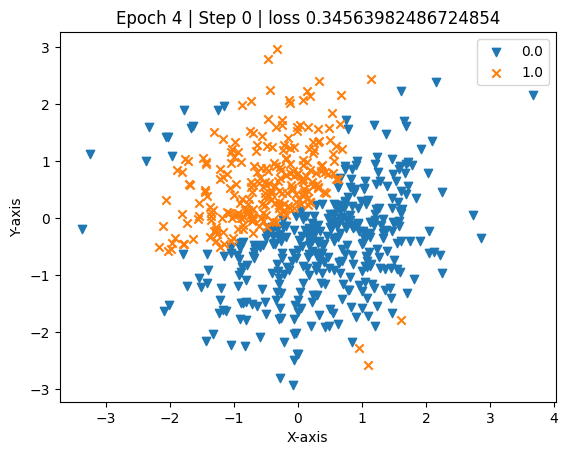

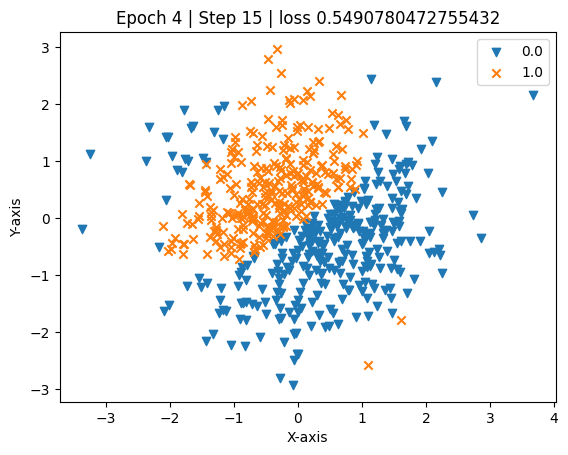

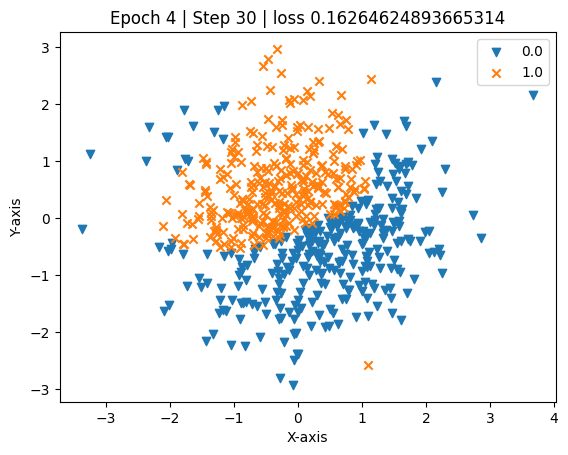

2024-09-23 02:04:22.261349: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] and In[1] has different ndims: [1] vs. [1,9]


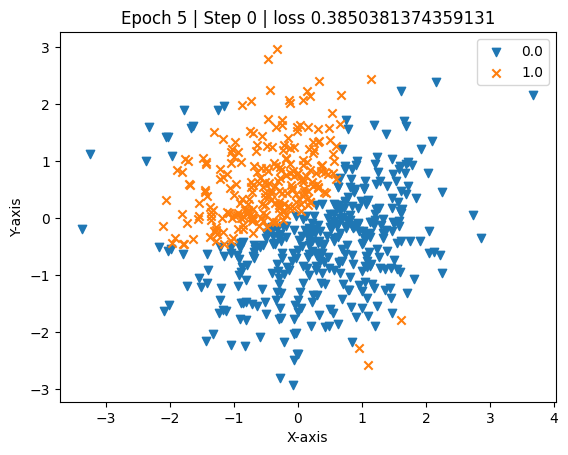

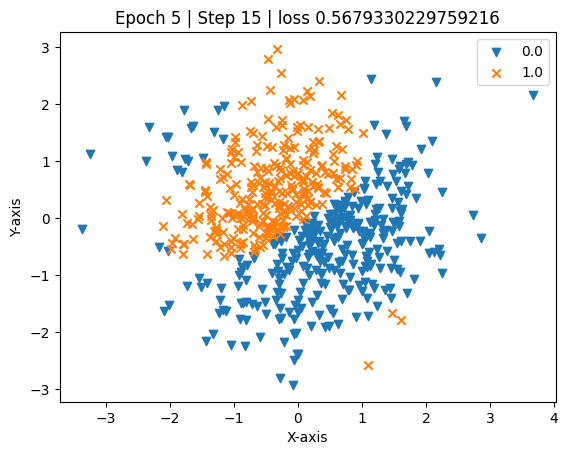

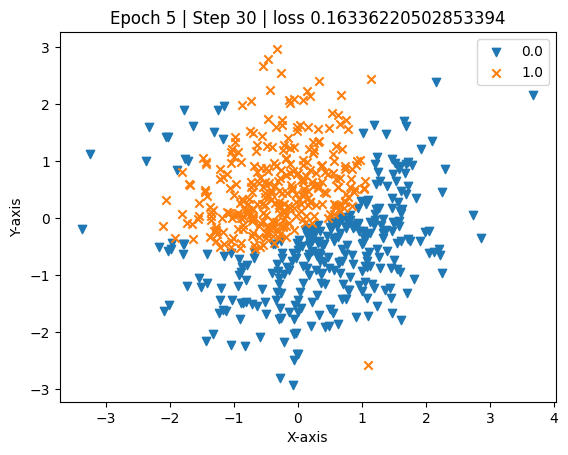

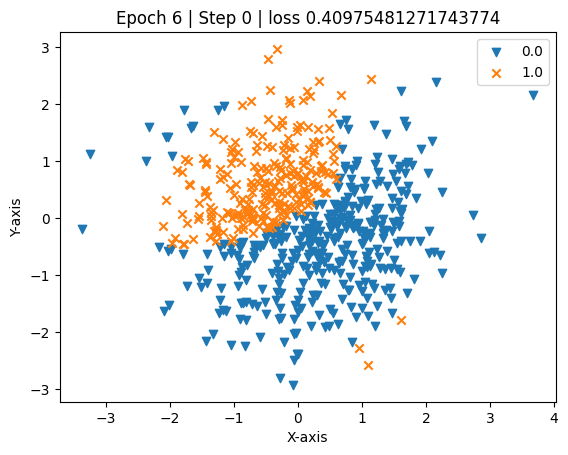

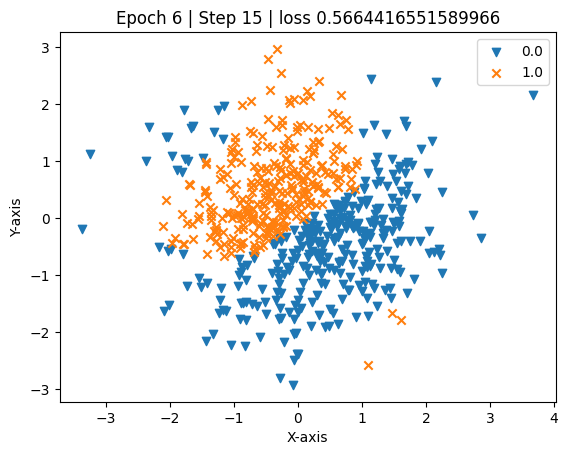

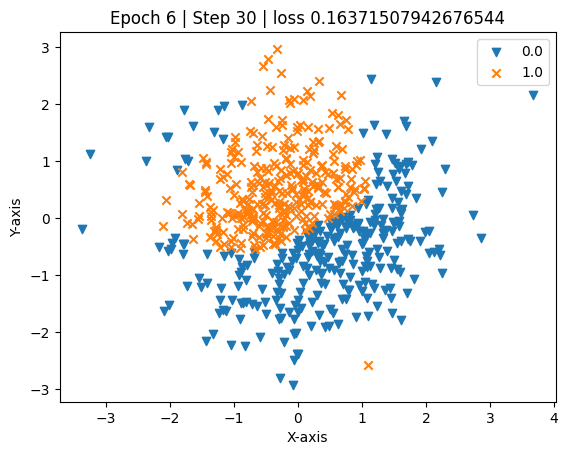

In [30]:
for epoch in range(epochs):
    plots = []
    for step in range(step_size):
        grads = []
        losses = []
        for datapoint,label in zip(dataset[step],y_true[step]):
            with tf.GradientTape() as tape:
                result = forward_pass(datapoint,weights)
                loss = lossfn(tf.expand_dims(label,0),result)
            grads.append(tape.gradient(loss,weights))
            losses.append(loss)
        grads = tf.reduce_sum(grads,axis=0)
        losses = tf.reduce_sum(losses,axis=0)
        opt.apply_gradients(zip([grads],[weights]))
        print(f"Finshed Step {step+1} of epoch {epoch+1} ---- loss : {loss}",end="\r") 
        with file_writer.as_default():
            tf.summary.scalar("Loss",loss,step=step_size*epoch+step)
        if(step%15 == 0):
            y_preds = get_model_preds(data[step:step+600],weights)
            img = plot_preds(y_preds.numpy(),data[step:step+600,0],data[step:step+600,1],title=f"Epoch {epoch + 1} | Step {step} | loss {loss}",get_img=True)
            with file_writer.as_default():
                tf.summary.scalar("Loss",loss,step=step_size*epoch+step)
                tf.summary.image("Training Progress", img, step=step_size*epoch+step)

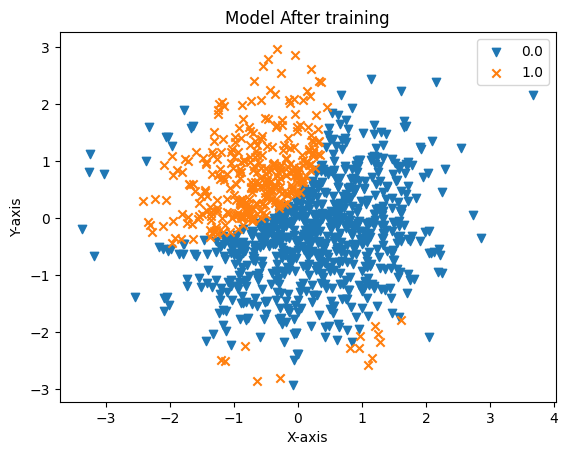

In [32]:
y_preds = get_model_preds(data,weights)
plots = plot_preds(y_preds.numpy(),data[:,0],data[:,1],title=f"Model After training",get_img=True)
with file_writer.as_default():
  tf.summary.image("Training Progress", plots, step=step_size*epoch+step+10)

In [31]:
np.save("./Saved_vars/weights_DR.npy",weights)

In [33]:
file_writer.close()